# Links to Datasets:

In [1]:
PATH_EIVP_DATASET_MESURES = "../data/EIVP_DATASET_MESURES.xlsx"
PATH_METEO = "../data/donnees-synop-essentielles-omm.xlsx"

# Main imports

In [5]:
%pip install openpyxl -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
# ----------------------------------- Utils ---------------------------------- #
from datetime import datetime
from pprint import pprint
import matplotlib.pyplot as plt

# ------------------------------- Data Analysis ------------------------------ #
import numpy as np
import pandas as pd

# ------------------------------ Data processing ----------------------------- #
from darts.dataprocessing.transformers import Scaler

# --------------------------- Prediction utils libs -------------------------- #
from darts.utils import missing_values
import darts

# --------------------------------- eval libs -------------------------------- #
import sklearn.metrics

# Load and create Dataset

prepare EIVP data

In [7]:
# ----------------------------------- load ----------------------------------- #
eivp = pd.read_excel(PATH_EIVP_DATASET_MESURES)
# ----------------------------- imp columns opnly ---------------------------- #
columns_of_interest_eivp=[
    "humidity",
    "lum",
    "temp",
    "co2",
    # "hpa",
    "sent_at",
]
eivp = eivp[columns_of_interest_eivp]
# ------------------------------ set date column ----------------------------- #
eivp['sent_at'] = pd.to_datetime(eivp['sent_at'])
eivp = eivp.rename(columns={'sent_at': 'Date'}) # rename column to Date
eivp = eivp.set_index('Date')
# --------------------------------- Resample --------------------------------- #
eivp = eivp.resample('3H', origin=datetime.strptime('2021-04-13 17:00:00', "%Y-%m-%d %H:%M:%S")).mean()

prepare Meteo data

In [8]:
# ----------------------------------- load ----------------------------------- #
meteo = pd.read_excel(PATH_METEO)
# ------------------------- filter important columns ------------------------- #
columns_of_interest_meteo=[
    "Date",
    # "Pression au niveau mer",
    "Direction du vent moyen 10 mn",
    "Vitesse du vent moyen 10 mn",
    # "TempÃ©rature",
    "HumiditÃ©",
    "Pression station",
    "TempÃ©rature (Â°C)",
]
meteo = meteo[columns_of_interest_meteo]
# ------------------------------ set date column ----------------------------- #
meteo["Date"] = pd.to_datetime(meteo["Date"])
meteo['Date'] = meteo['Date'].dt.tz_localize(None)

Merge data

In [9]:
data = eivp.merge(meteo, on='Date')

# Convert data into series

In [40]:
series = darts.TimeSeries.from_dataframe(data, 'Date', fill_missing_dates=True)
# The previous line contains "fill_missing_values" flag. This might create some nan values.
series = missing_values.fill_missing_values(series) # Fill nan values

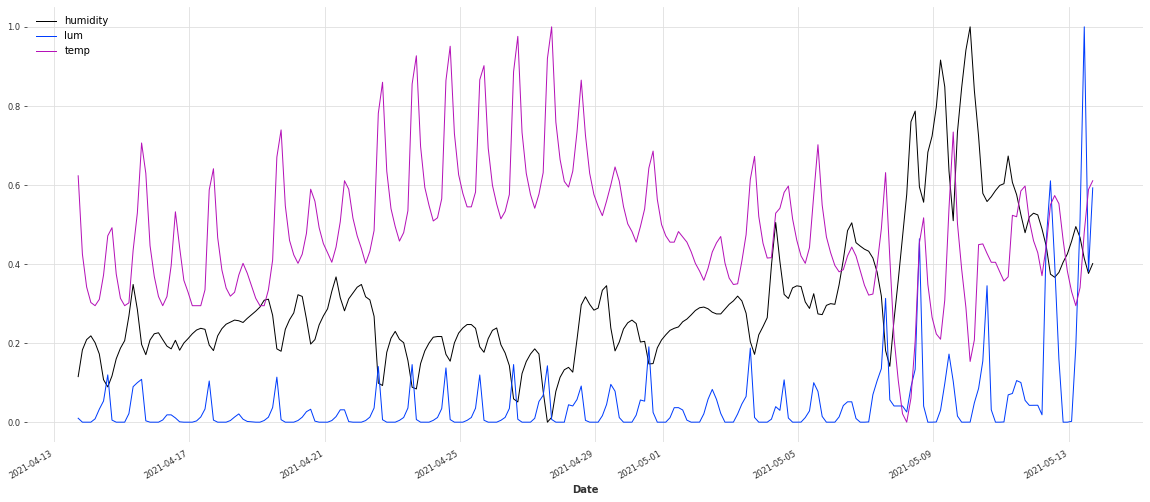

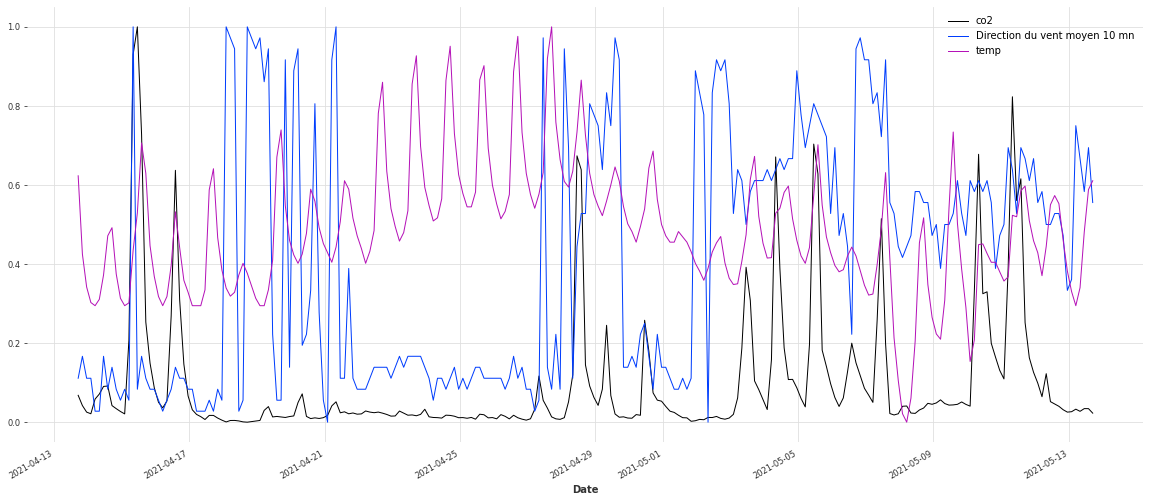

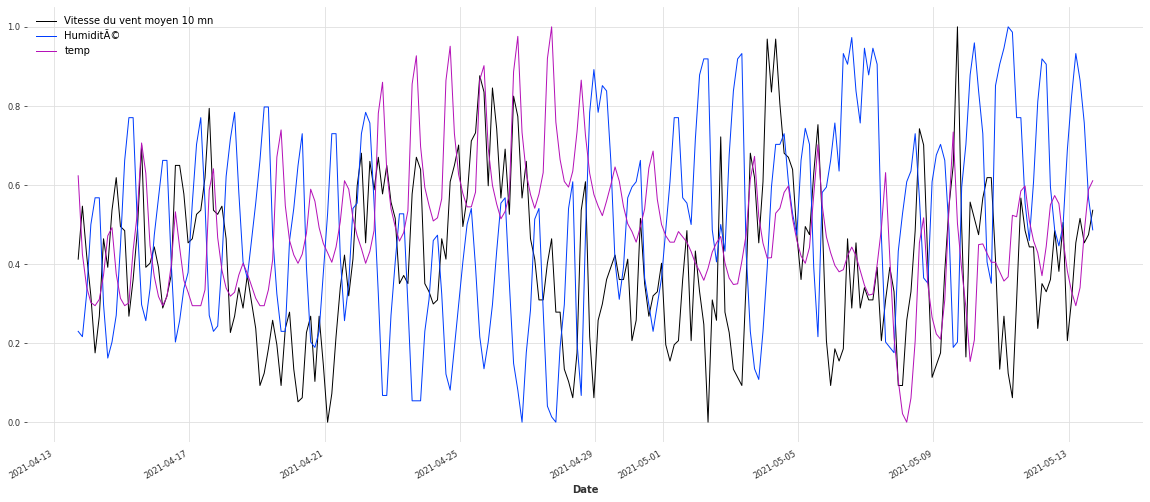

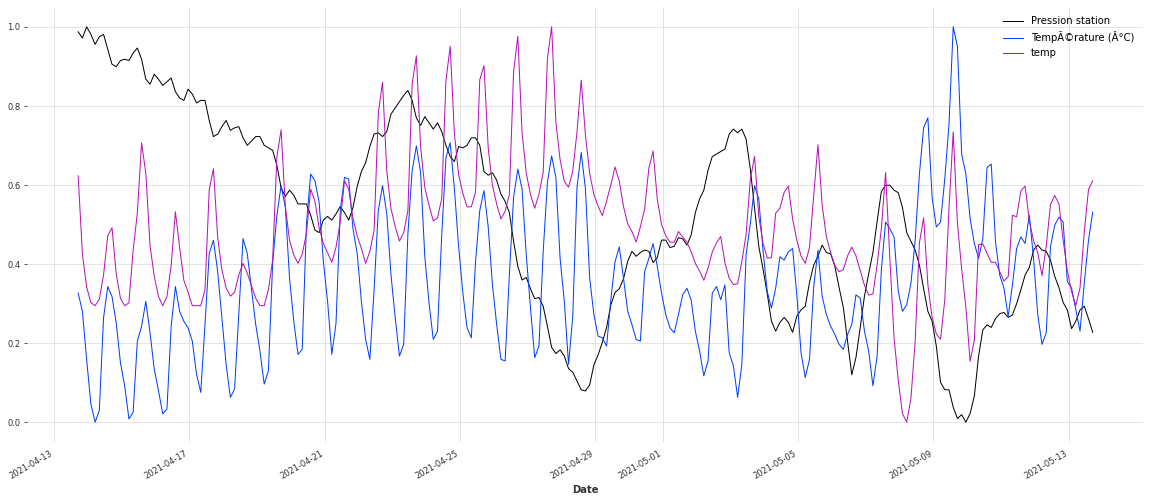

In [78]:
cols = list(series.columns)
scaler = Scaler()

lw = 1 # Stroke of the line for plotting

plt.figure(figsize=(20, 8))
scaler.fit_transform(series[cols[:3]]).plot(lw=lw)
plt.show()

plt.figure(figsize=(20, 8))
scaler.fit_transform(series[cols[3:5] +["temp"]]).plot(lw=lw)
plt.show()

plt.figure(figsize=(20, 8))
scaler.fit_transform(series[cols[5:7] +["temp"]]).plot(lw=lw)
plt.show()

plt.figure(figsize=(20, 8))
scaler.fit_transform(series[cols[7:9] +["temp"]]).plot(lw=lw)
plt.show()

# Split data

It is important to split the data using the date to guarantee no Bias in any of the models. The dimensionality of the data is high (in comparission to its length) and the models might overfit to the data points.

Lets say we take 80% of the data for training and 20% for testing.

In [79]:
train_ratio = 0.8
l_train = int(len(series)*train_ratio)
train, test = series[:l_train], series[l_train:]

# Time Series approach

In [13]:
target = ['temp']